In [266]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [267]:
#Carico il dataset

data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})

data = data.sample(frac=1, random_state=8324).reset_index(drop=True) #shuffle
print("Shape del dataset : ", data.shape)

Shape del dataset :  (13451, 22)


Total :  13451
Normal :  7500
Malicious :  5951


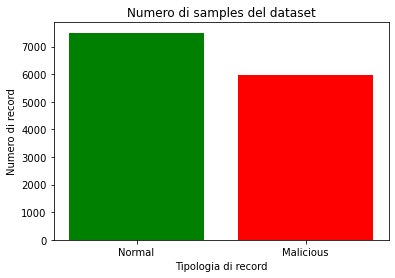

In [268]:
#Effettuo il plot del dataset

total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

In [269]:
#funzioni utili per il preprocessing

#effettua il preprocessing di una features già numerica
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
#per il preprocessing di features non numeriche
def encode_text_features(df):
    le = LabelEncoder()
    df_2 = df.apply(le.fit_transform)
    enc = OneHotEncoder()

    enc.fit(df_2)

    onehotlabels = enc.transform(df_2).toarray()
    return onehotlabels

In [270]:
#preprocessing
def preprocessing(data):
    
    data_objects = data.select_dtypes(include=[object]) #df con solo features non numeriche
    
    data_numerics = data.drop(['protocol_type', 'service', 'flag'], axis=1) #df con solo features numeriche
    
    #preprocessing features numeriche
    encode_numeric_zscore(data_numerics, 'duration')
    encode_numeric_zscore(data_numerics, 'src_bytes')
    encode_numeric_zscore(data_numerics, 'dst_bytes')
    encode_numeric_zscore(data_numerics, 'land')
    encode_numeric_zscore(data_numerics, 'wrong_fragment')
    encode_numeric_zscore(data_numerics, 'urgent')
    encode_numeric_zscore(data_numerics, 'hot')
    encode_numeric_zscore(data_numerics, 'num_failed_logins')
    encode_numeric_zscore(data_numerics, 'logged_in')
    encode_numeric_zscore(data_numerics, 'num_compromised')
    encode_numeric_zscore(data_numerics, 'root_shell')
    encode_numeric_zscore(data_numerics, 'su_attempted')
    encode_numeric_zscore(data_numerics, 'num_root')
    encode_numeric_zscore(data_numerics, 'num_file_creations')
    encode_numeric_zscore(data_numerics, 'num_shells')
    encode_numeric_zscore(data_numerics, 'num_access_files')
    encode_numeric_zscore(data_numerics, 'is_guest_login')
    encode_numeric_zscore(data_numerics, 'count')
    
    df_duration = data_numerics.duration #prelevo solo la colonna "duration" per concatenare come il df originale
    
    data_numerics = data_numerics.drop('duration', axis=1) #rimuovo la colonna duration
    
    #preprocessing del dataframe con features non numeriche
    np_to_add = encode_text_features(data_objects)
    
    #dato che restituisce un array numpy effettuo la conversione a df
    df_to_add = pd.DataFrame(data=np_to_add)
    
    #concatenazione per riottenere il df nella formattazione originale
    frames = [df_duration, df_to_add, data_numerics]
    data_finale = pd.concat(frames, axis=1)
    return data_finale
    

In [271]:
data = preprocessing(data)
normal_data = data[data.result == "normal"] #prendo solo i valori "normali" 

#voglio che sia il train che la validation siano effettuati su record normali ma che siano tra loro differenti

data_train, data_val, data_test = np.split(normal_data, [int(.6*len(normal_data)), int(.8*len(normal_data))])

print("Data Train Shape : ",data_train.shape)
print("Data Train Shape : ",data_val.shape)
        
x_train = data_train.drop('result',axis=1) #rimuove la colonna result dal dataframe
x_val = data_val.drop('result', axis=1) #rimuove il label

print("Shape dataframe per il train : ", x_train.shape)
print("Shape dataframe per la validation : ", x_val.shape)

Data Train Shape :  (4500, 100)
Data Train Shape :  (1500, 100)
Shape dataframe per il train :  (4500, 99)
Shape dataframe per la validation :  (1500, 99)


In [272]:
model = keras.Sequential(
    [
       layers.Input(shape=(x_train.shape[1],)),
       layers.Dense(512),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(256),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(128),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
        
       layers.Dense(64),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
        
       layers.Dense(128),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(256),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(512),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(x_train.shape[1], activation='sigmoid')
    ]
)

model.compile( optimizer='adam', loss='mse')
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_167 (Dense)            (None, 512)               51200     
_________________________________________________________________
dropout_146 (Dropout)        (None, 512)               0         
_________________________________________________________________
leaky_re_lu_146 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_168 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_147 (Dropout)        (None, 256)               0         
_________________________________________________________________
leaky_re_lu_147 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_169 (Dense)            (None, 128)             

In [273]:
history = model.fit(
    x_train,
    x_train,
    epochs=30,
    batch_size=5,
    validation_data=(x_val, x_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min")
    ],
)

Epoch 1/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0535 - val_loss: 0.1892
Epoch 2/30
900/900 [==============================] - 2s 2ms/step - loss: 0.0484 - val_loss: 0.1870
Epoch 3/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0479 - val_loss: 0.1872
Epoch 4/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0475 - val_loss: 0.1864
Epoch 5/30
900/900 [==============================] - 3s 4ms/step - loss: 0.0466 - val_loss: 0.1853
Epoch 6/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0448 - val_loss: 0.1853
Epoch 7/30
900/900 [==============================] - 2s 2ms/step - loss: 0.0448 - val_loss: 0.1853
Epoch 8/30
900/900 [==============================] - 2s 3ms/step - loss: 0.0447 - val_loss: 0.1856
Epoch 9/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0447 - val_loss: 0.1853
Epoch 10/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0446 - val_loss: 0.1853

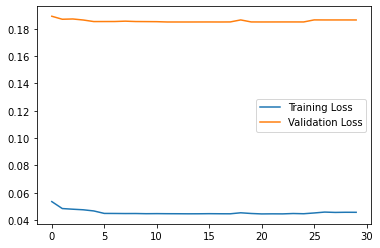

In [274]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

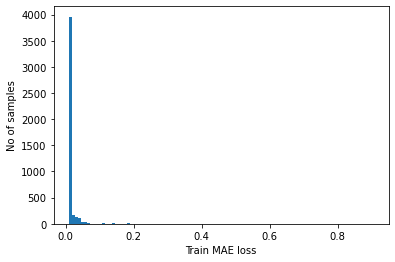

Reconstruction error threshold:  0.01692707148149886


In [275]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
train_mae_loss = train_mae_loss.ravel() #converte l'array numpy in 1d
train_mae_loss = np.sort(train_mae_loss) #quicksort


train_mae_loss_len = len(train_mae_loss)
n_index = int(0.75*train_mae_loss_len)
plt.hist(train_mae_loss, bins=100)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
train_mae_loss_split = train_mae_loss[:n_index]
threshold = np.max(train_mae_loss_split)
print("Reconstruction error threshold: ", threshold)

In [276]:
#data_test
#il dataset per il test sarà formato dai 1500 sample normali prelevati precedentemente a cui aggiungerò dei sample anomali
#in particolare prelevo il 20% dei sample anomali e li concateno ai 1500 normali precedentemente ottenuti

anomaly_data = data[data.result != "normal"] #prendo solo i valori "anomali"

percentage = 20
anomaly_test_data = anomaly_data.head(int(len(anomaly_data)*(percentage/100)))

frames = [data_test, anomaly_test_data]
final_test_data = pd.concat(frames)

print("Shape del dataset per il test: ", final_test_data.shape)

Shape del dataset per il test:  (2690, 100)


Total :  2690
Normal :  1500
Malicious :  1190


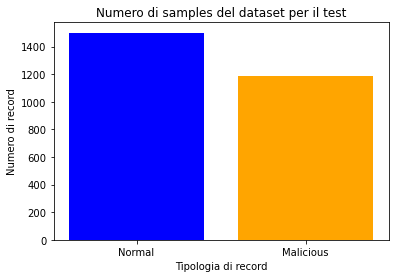

x_test shape : (2690, 99)


In [277]:
total_flows_count_test = final_test_data["result"].count()
normal_flows_count_test = len(final_test_data[final_test_data.result == "normal"])
anomaly_flows_count_test = len(final_test_data[final_test_data.result != "normal"])

print("Total : ",total_flows_count_test)
print("Normal : ",normal_flows_count_test)
print("Malicious : ",anomaly_flows_count_test)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count_test, anomaly_flows_count_test] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['blue', 'orange']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset per il test') 
  
plt.show() 

data_test_with_label = final_test_data.copy()
x_test = final_test_data.drop('result',axis=1) #rimuove la colonna result dal dataframe
print("x_test shape :", x_test.shape)

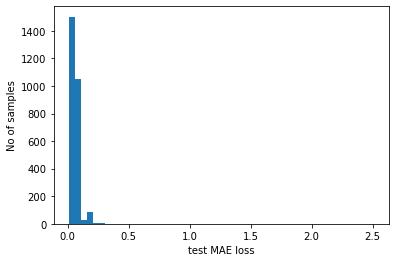

Number di sample anomali rilevati:  1545
Numero di sample anomali rivelati erroneamente:  355
Numero di sample anomali rilevati correttamente:  1190
Numero di sample anomali non rivelati:  0


Indices of anomaly samples:  (array([   3,   11,   14, ..., 2687, 2688, 2689], dtype=int64),)


In [278]:
arr_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(arr_test_pred - x_test), axis=1)
#test_mae_loss = test_mae_loss.reshape((-1))
                                       
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()


# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
count = 0
false_negative = 0
false_positive = 0


for i in anomalies:
    if ( i == True ):
        if ( data_test_with_label.iloc[count].result == "normal"):
            false_negative = false_negative + 1
    if (i == False):
        if( data_test_with_label.iloc[count].result != "normal"):
            false_positive = false_positive + 1
    count = count + 1
        
print("Number di sample anomali rilevati: ", np.sum(anomalies))
print("Numero di sample anomali rivelati erroneamente: ", false_negative)
print("Numero di sample anomali rilevati correttamente: ", np.sum(anomalies)-false_negative)
print("Numero di sample anomali non rivelati: ", false_positive)
print("")
print("")
print("Indices of anomaly samples: ", np.where(anomalies))                                       